In [8]:
library(ggplot2)
library(tidyverse) 
library(ggtree)
library(gridExtra) 
library(viridis)
library(cowplot)
library(reshape2)
library(ape)
library(ggnewscale)

library(ggrepel) 

In [4]:
# if (!requireNamespace("BiocManager", quietly = TRUE))
#   install.packages("BiocManager", repos = "https://cloud.r-project.org")

# BiocManager::install("ggtree", ask = FALSE, update = FALSE)

In [9]:
# install.packages('ggrepel')

In [10]:
epi_clusters <- read.csv('../data/epi_clusters.csv')[,-1]


In [16]:
df_short <- epi_clusters %>% select(Sample.1,Sample.2, SNPs,DateCollection.x,DateCollection.y,
                          Source.x, Source.y,HOSP.x,HOSP.y,Patient.x, Patient.y,diff_days, average24.x, average24.y, score_cat,nRoom.x,nRoom.y)
df_short <- df_short %>% 
mutate(score_cat = case_when(score_cat == 'same_room_env' ~ 'Same Room',
                            TRUE ~ score_cat)) %>% 
mutate(score_cat = case_when(score_cat == 'Same_Patient' ~ 'Same Patient',
                            TRUE ~ score_cat))

In [17]:
df_short <- df_short %>% 
mutate(Source2.x = case_when(Source.x == 'Clinical' ~ Patient.x,
                                         TRUE ~ Source.x)) %>%
mutate(Source2.y = case_when(Source.y == 'Clinical' ~ Patient.y,
                                         TRUE ~ Source.y))

In [18]:
mc_data <- rbind(df_short %>% 
select(Sample.1,DateCollection.x,Source.x,Source2.x,HOSP.x,Patient.x,average24.x, nRoom.x) %>%
rename(Sample = 'Sample.1',Date.of.Collection='DateCollection.x',Source='Source.x',Source2='Source2.x',Patient='Patient.x',
       average24='average24.x', ROOM='nRoom.x', HOSP='HOSP.x'),

df_short %>% select(Sample.2,DateCollection.y,Source.y,Source2.y,HOSP.y,Patient.y,average24.y, nRoom.y) %>%
rename(Sample = 'Sample.2',Date.of.Collection='DateCollection.y',Source='Source.y',Source2='Source2.y',Patient='Patient.y',
       average24='average24.y', ROOM='nRoom.y',HOSP='HOSP.y')) %>%
distinct()

In [21]:
non_clonal_set <- read.csv('../data/non_clonal_set2_tab.csv')[,-1]


In [25]:
### Read Tree
##Cluster number

n=15

tree <- read.tree(paste('../data/ClustersTrees/clus',n,'.tree', sep=''))
## detect the focal sample
test <- non_clonal_set %>% filter(NML.number %in% tree$tip.label)

earliest <- min(test$Date.of.Collection.x)
earliest

# Filter the focal samples based on the earliest date
focal_samples <- test %>%
  filter(Date.of.Collection.x == earliest) %>%
  select(NML.number) %>%
  distinct()
focal_samples$NML.number

### Root the tree with focal samples

rtree <- root(tree, outgroup = focal_samples$NML.number, resolve.root = TRUE)

t <- ggtree(rtree)+
geom_tiplab(size=6)

# Get order of taxa on tree
tip_order <- get_taxa_name(t)
tip_order

[1] "2018-01-30"

[1] "N19-02213"

[1] "N19-03534" "N19-03512" "N19-04693" "N19-03986" "N19-03565" "N19-04000"
[7] "N19-02212" "N19-02230" "N19-02213"

In [26]:
non_clonal_pairs <- 
df_short %>% filter(`Sample.1` %in% tip_order) %>%
filter(`Sample.2` %in% tip_order)

### Clusters
test <-
non_clonal_pairs 

test1 <- test 

test2 <- test1 %>% filter(Sample.1==focal_samples$NML.number) %>%
select(Sample.1,Sample.2,SNPs,DateCollection.x,DateCollection.y,
       Source.x,Source.y,Source2.x,Source2.y,score_cat)

test3 <- test1 %>% filter(Sample.2==focal_samples$NML.number) %>%
select(Sample.2,Sample.1,SNPs,DateCollection.y,DateCollection.x,
       Source.y,Source.x,Source2.y,Source2.x,score_cat)
colnames(test3) <- c('Sample.1','Sample.2','SNPs','DateCollection.x',	
                     'DateCollection.y','Source.x','Source.y','Source2.x','Source2.y','score_cat')

test4 <- rbind(test2,test3)

In [27]:
# Step 1: Extract the first row values for .1 and .x variables
first_row <- test4[1, ]
print(first_row)
# Step 2: Create the artificial row
artificial_row <- data.frame(
  Sample.1 = first_row$Sample.1,
  Sample.2 = first_row$Sample.1,  # Duplicate for .2 variable
  SNPs = 0,  # Set to 0
  DateCollection.x = first_row$DateCollection.x,
  DateCollection.y = first_row$DateCollection.x,  # Duplicate for .y variable
  Source.x = first_row$Source.x,
  Source.y = first_row$Source.x,  # Duplicate for .y variable
      Source2.x = first_row$Source2.x,
  Source2.y = first_row$Source2.x,  # Duplicate for .y variable
  # Duplicate for .y variable
  score_cat = NA  # Set to NA
)
artificial_row
# Step 3: Bind the artificial row to the original data
# test_with_artificial_row <- 
test4 <- rbind( artificial_row,test4)

   Sample.1  Sample.2 SNPs DateCollection.x DateCollection.y      Source.x
1 N19-02213 N19-02230    2       2018-01-30       2018-03-05 Environmental
       Source.y     Source2.x     Source2.y score_cat
1 Environmental Environmental Environmental Same Room


Sample.1,Sample.2,SNPs,DateCollection.x,DateCollection.y,Source.x,Source.y,Source2.x,Source2.y,score_cat
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>
N19-02213,N19-02213,0,2018-01-30,2018-01-30,Environmental,Environmental,Environmental,Environmental,NA


Sample.1,Sample.2,SNPs,DateCollection.x,DateCollection.y,Source.x,Source.y,Source2.x,Source2.y,score_cat
<chr>,<chr>,<dbl>,<date>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>
N19-02213,N19-02213,0,2018-01-30,2018-01-30,Environmental,Environmental,Environmental,Environmental,NA


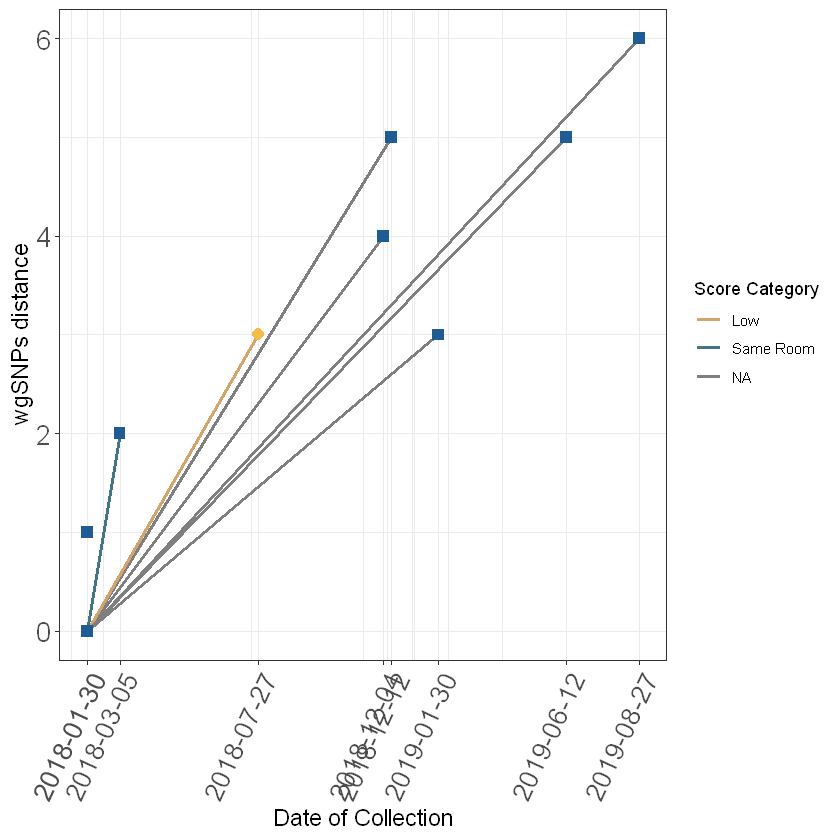

In [28]:
### focal sample figure
score_cat_colors <- c('High'='#771427','Medium'='#AA5C39','Low'='#D4A56A','Not-linked'='#D4CC6A',
                      'Same Patient'='#672770','Same Room'='#457585', 'NA'='grey')

test4$DateCollection.x <- as.Date(test4$DateCollection.x, format="%Y-%m-%d")
test4$DateCollection.y <- as.Date(test4$DateCollection.y, format="%Y-%m-%d")

# Step 1: Identify the first dot (earliest date)
earliest_point <- test4 %>%
  arrange(DateCollection.x) %>%
  slice(1)  # Get the first row
earliest_point
# Step 2: Create connections from the first dot to all other dots
connections <- test4 %>%
  filter(DateCollection.y != earliest_point$DateCollection.y) %>%
  mutate(x_start = earliest_point$DateCollection.y,
         y_start = earliest_point$SNPs,
         color = score_cat)  # Keeping color for lines

 
# Step 3: Plot the points and lines
p <- ggplot() +
  # Plot the segments with the second color scale
  geom_segment(data = connections,
               aes(x = x_start, xend = DateCollection.y, 
                   y = y_start, yend = SNPs, colour = as.factor(score_cat)),
               linewidth = 1) +
  # Second color scale for the segments
  scale_color_manual(name = "Score Category", values = score_cat_colors) +
    new_scale_color() +
  # Plot the points with the first color scale
  geom_point(data = test4, 
             aes(x = DateCollection.y, y = SNPs, color = Source.y, shape=Source2.y), 
             size = 3,show.legend = FALSE) +
  # First color scale for the points
# scale_color_viridis_d(name='Source')+
scale_color_manual(values = c('#F3BD4C','#1F5C93'),na.translate = F, name='Source')+
scale_shape_manual(values = c(15,16,17,18,19,20,21,22,25,1,3),na.value = 11, name='Patient')+
  scale_x_date(breaks = test4$DateCollection.y,  # Set the breaks to the isolation dates
               labels = format(test4$DateCollection.y, "%yyyy-%m-%d"),  # Format as Month Day, Year
               date_labels = "%Y-%m-%d")+   # Show month and year on the axis

  # Additional plot formatting
  theme_bw() +
  theme(axis.text.x = element_text(angle = 65, hjust = 1, size=16),
        axis.text.y = element_text(size=16),
        axis.title.y = element_text(size=14),
        axis.title.x = element_text(size=14),
        legend.position = "right")  +
  labs(y = 'wgSNPs distance', x = 'Date of Collection')# Step 1: Identify the first dot (earliest date)
# ggtitle(paste('Cluster ',n,sep=''))
# Print the plot
p 
legend_source <- get_legend(p)
ggsave(paste('../output/Cluster_ELS',n,'.png', sep=''), device = 'png', dpi = 350, width=15, height=10)

# p+guides(color = guide_legend(order = 1)) 


In [32]:
hosp_palette <- c('N'='#FFAAAA','L'='#7E82B1','M'='#FFFAAA','H'='#88CC88','J'='#FDBF6F','S'='#BE7FAD','T'='#CA6573')
hosp_data <- data.frame(
  Category = names(hosp_palette),
  Value = rep(1, length(hosp_palette))  
)

score_cat_colors <- c('High'='#771427','Medium'='#AA5C39','Low'='#D4A56A','Not-linked'='#D4CC6A',
                      'Same Patient'='#672770','Same Room'='#457585', 'NA'='grey')
score_data <- data.frame(
  Category = names(score_cat_colors),
  Value = rep(1, length(score_cat_colors)) 
)

scale_color_brewer_skip_first <- function(palette = "Paired", n = 8) {
  colors <- scales::brewer_pal(palette = palette)(n)
  colors <- colors[-1]  # Remove the first color
  scale_color_manual(values = colors)
}

In [33]:
### Line plot

library(RColorBrewer)

set_test <- 
mc_data %>% filter(average24==n)

set_test$Date.of.Collection <- as.Date(set_test$Date.of.Collection, format="%Y-%m-%d")

set_test$ROOM <- gsub('&','/',set_test$ROOM)

set_test$ROOM <- gsub(';','/',set_test$ROOM)

set_test$ROOM <- gsub(' ','',set_test$ROOM)

# Create the custom palette
# original_palette <- brewer.pal(12, "Paired")  # Extract colors from the Paired palette
# original_palette <- original_palette[-c(1,2,3)]
# custom_palette <- c("#1F5C93", (original_palette))  # Add your custom color


# Calculate the date range for each ROOM, HOSP.x, and Source.x combination
room_ranges <- set_test %>%
  group_by(ROOM, HOSP, Source2) %>%
  summarise(start_date = min(Date.of.Collection, na.rm = TRUE),
            end_date = max(Date.of.Collection, na.rm = TRUE),
            .groups = 'drop') # Drop extra grouping
room_ranges
# Create the plot


rooms <- ggplot() +
  # Segments layer
  geom_segment(data = room_ranges,
               aes(x = start_date-3, 
                   xend = end_date+3, 
                   y = ROOM, 
                   yend = ROOM, 
                   color = as.factor(HOSP)), 
               linewidth = 7, alpha = 0.5) +
  scale_color_manual(values = hosp_palette, name='Hospital') +
  new_scale_color() +
  # Points layer

  geom_point(data = set_test, 
             aes(x = Date.of.Collection, 
                 y = ROOM, 
                 color = Source2), 
             size = 4, alpha = 0.7) +
  # scale_color_brewer(palette = 'Paired') +
  scale_color_brewer_skip_first(palette = "Set2") +

  # Customizing the x-axis labels
  # scale_x_date(breaks = set_test$Date.of.Collection.x,  # Set the breaks to the isolation dates
  #              labels = format(set_test$Date.of.Collection.x, "%yyyy-%m-%d"),  # Format as Month Day, Year
  #              date_labels = "%Y-%m-%d") +  # Show month and year on the axis
  scale_x_date(breaks = test4$DateCollection.y,  # Set the breaks to the isolation dates
               labels = format(test4$DateCollection.y, "%yyyy-%m-%d"),  # Format as Month Day, Year
               date_labels = "%Y-%m-%d",
               guide = guide_axis(check.overlap = TRUE))+
  labs(x = "Date of Collection", y = "ROOM", color = "Source/Patient", fill='Hospital') +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, size=14),
        axis.text.y = element_text(size=12),
       axis.title.y = element_text(size=14),
       axis.title.x = element_text(size=14)) +
  guides(fill = "none")  # Remove fill legend

legend_room <- get_legend(rooms)


ROOM,HOSP,Source2,start_date,end_date
<chr>,<chr>,<chr>,<date>,<date>
1802,M,Environmental,2018-12-04,2019-08-27
1804,M,Environmental,2018-01-30,2018-03-05
NA,M,M0009,2018-07-27,2018-07-27


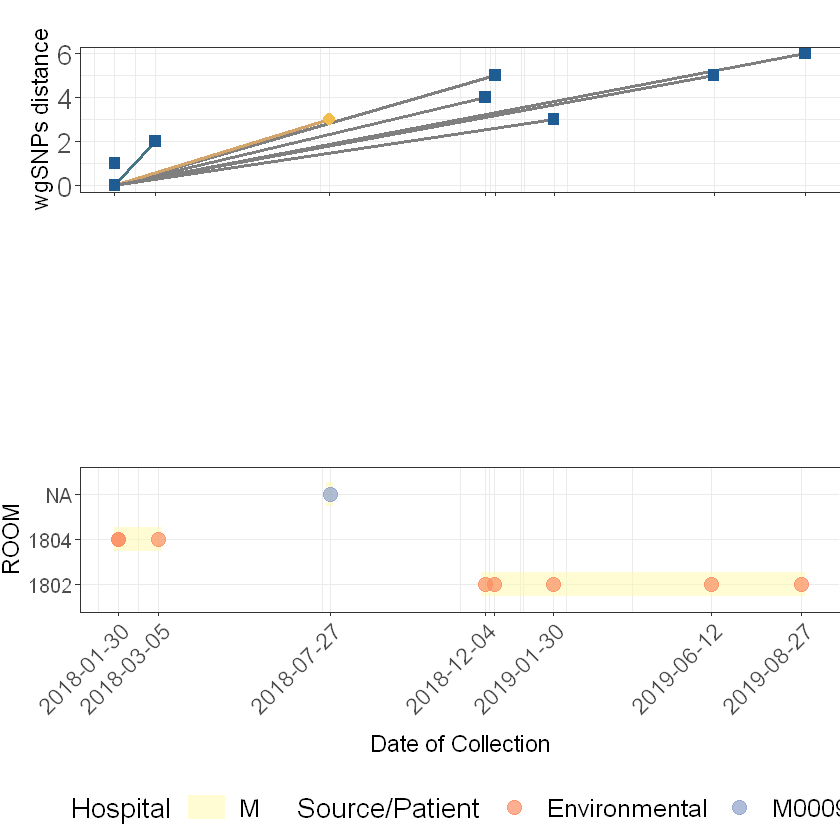

In [39]:
plot <- plot_grid(p+theme(axis.text.x = element_blank(),
                  axis.title.x = element_blank(),
                  legend.position = 'none',
                plot.margin = margin(t = 1, r = 0, b = 0, l = 0, unit = "cm")),
                  NULL,
          rooms+theme(legend.position = 'bottom',
                     legend.direction = 'horizontal')+
            theme(legend.key.size = unit(1, 'cm'), #change legend key size
        legend.key.height = unit(1, 'cm'), #change legend key height
        legend.key.width = unit(1, 'cm'), #change legend key width
        legend.title = element_text(size=17), #change legend title font size
        legend.text = element_text(size=15),
                 plot.margin = margin(t = 0, r = 0, b = 0, l = 0, unit = "cm")) #change legend text font size
          , ncol=1, align = 'hv', axis = 'tblr', rel_heights = c(1,0.000001,1))
plot

In [36]:
library(grid)        # For rasterGrob function
library(magick)      # For reading image files

In [37]:
# Load the PNG image and convert to a rasterGrob
image_path <- paste("../data/ClustersTrees/Tree_Map_c",n,".png", sep='')  # Replace with your image path
img <- image_read(image_path)           # Read the image using magick
img_grob <- rasterGrob(img)             # Convert to rasterGrob


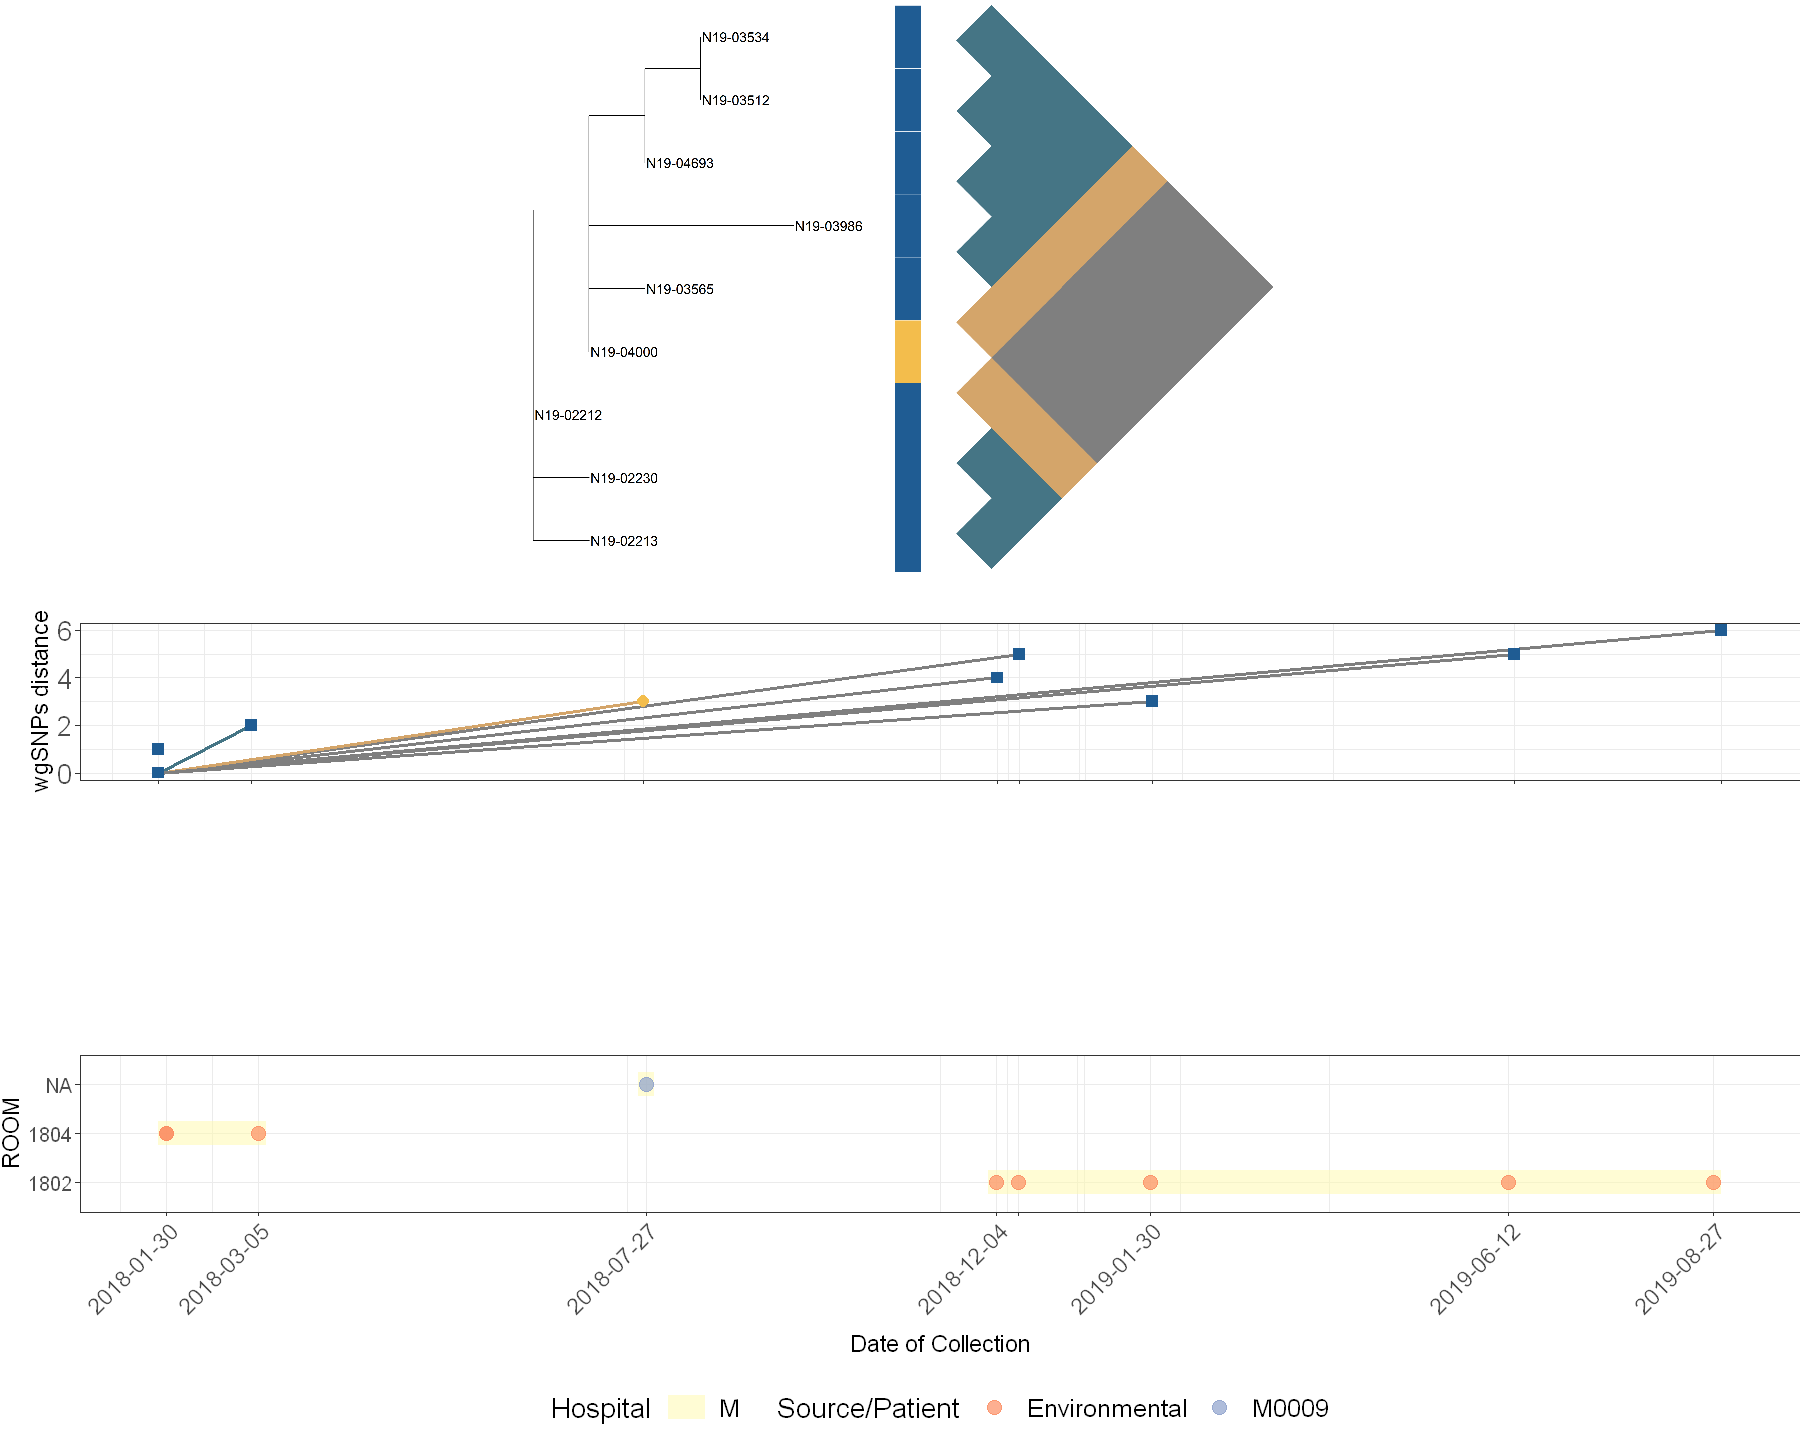

In [41]:
options(repr.plot.width = 15, repr.plot.height = 12)

# Combine the ggplot object and the image using plot_grid
combined_plot <- plot_grid(
      img_grob,                  # The image as rasterGrob
  plot,                     # The ggplot object
  nrow = 2,                  # Arrange in 2 columns
  rel_heights = c(1, 1.5),       # Adjust relative widths if necessary
rel_widths = c(1, 0.8)
)
combined_plot